s# Ring Artifact Investigation

This notebook investigates the unexplained ring features observed in pair-stacked κ maps,
particularly visible at ~10 and ~30 Mpc/h radius around each galaxy peak.

## Tests Performed

**Test 4a**: Split CMASS (North) galaxies into two subsamples by galactic latitude b:
- High-b subsample (b > b_median)
- Low-b subsample (b < b_median)
- Check if ring features appear in both, one, or neither subsample

**Test 4b**: Check single-galaxy stacked κ map for rings:
- Compare ring positions in single-galaxy vs pair-stacked maps
- If rings appear in single-galaxy map at same radii, artifact is not from pair alignment

In [97]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy.io import fits
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

# Import helper functions
from helper import load_catalog, preprocess_catalog_galactic, symmetrize_map, radial_profile

In [98]:
# --- Settings ---
h = cosmo.h
nside = 2048
fwhm_rad = np.radians(8 / 60)  # 8 arcmin smoothing

# Grid parameters
box_size_hmpc = 100.0  # Mpc/h
grid_size = 100
grid_res = 101  # For pair stacking compatibility
cell_size_hmpc = box_size_hmpc / grid_size
half_box = box_size_hmpc / 2
extent = [-half_box, half_box, -half_box, half_box]

# Separation to investigate (20 Mpc/h shows clearest rings)
separation = 10
buffer = 2 if separation > 10 else 1

print(f"Investigating ring artifacts for {separation} Mpc/h pair separation")

Investigating ring artifacts for 10 Mpc/h pair separation


## Load Data

In [99]:
# --- Load Planck κ map and mask ---
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

print("Loading Planck κ map...")
alm_data = hp.read_alm(alm_file)
lmax = hp.Alm.getlmax(len(alm_data))
kmap = hp.alm2map(hp.smoothalm(alm_data, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)
print(f"κ map loaded: nside={nside}, lmax={lmax}")

Loading Planck κ map...
κ map loaded: nside=2048, lmax=4096


In [100]:
# --- Load pair catalog ---
# Try BOSS CMASS North+South first
pair_files = [
    f'data/paircatalogs/galaxy_pairs_catalog_CMASS_North_{separation}_{separation-buffer}_{separation+buffer}hmpc.csv',
    f'data/paircatalogs/galaxy_pairs_catalog_CMASS_South_{separation}_{separation-buffer}_{separation+buffer}hmpc.csv',
]

pairs_list = []
for f in pair_files:
    try:
        df = pd.read_csv(f)
        pairs_list.append(df)
        print(f"Loaded {len(df)} pairs from {f}")
    except FileNotFoundError:
        print(f"Not found: {f}")

if not pairs_list:
    # Try alternate naming
    alt_file = f'data/paircatalogs/galaxy_pairs_catalog_{separation}hmpc.csv'
    try:
        pairs_list.append(pd.read_csv(alt_file))
        print(f"Loaded {len(pairs_list[-1])} pairs from {alt_file}")
    except FileNotFoundError:
        print(f"Not found: {alt_file}")

if pairs_list:
    pairs = pd.concat(pairs_list, ignore_index=True)
    print(f"\nTotal pairs loaded: {len(pairs)}")
else:
    raise FileNotFoundError("No pair catalog found!")

Loaded 338313 pairs from data/paircatalogs/galaxy_pairs_catalog_CMASS_North_10_9_11hmpc.csv
Loaded 120729 pairs from data/paircatalogs/galaxy_pairs_catalog_CMASS_South_10_9_11hmpc.csv

Total pairs loaded: 459042


In [101]:
# --- Analyze galactic latitude distribution ---
# Use the midpoint b of each pair
b_mid = (pairs['b1'] + pairs['b2']) / 2

b_median = np.median(b_mid)
b_mean = np.mean(b_mid)

print(f"Galactic latitude (b) statistics:")
print(f"  Min: {b_mid.min():.2f}°")
print(f"  Max: {b_mid.max():.2f}°")
print(f"  Mean: {b_mean:.2f}°")
print(f"  Median: {b_median:.2f}°")

# Split threshold
b_threshold = b_median
print(f"\nUsing b_threshold = {b_threshold:.2f}° (median) for splitting")

# Create masks for high-b and low-b subsamples
high_b_mask = b_mid > b_threshold
low_b_mask = b_mid <= b_threshold

print(f"\nSubsample sizes:")
print(f"  High-b (b > {b_threshold:.1f}°): {high_b_mask.sum()} pairs")
print(f"  Low-b (b <= {b_threshold:.1f}°): {low_b_mask.sum()} pairs")

Galactic latitude (b) statistics:
  Min: -71.57°
  Max: 89.80°
  Mean: 28.57°
  Median: 48.36°

Using b_threshold = 48.36° (median) for splitting

Subsample sizes:
  High-b (b > 48.4°): 229521 pairs
  Low-b (b <= 48.4°): 229521 pairs


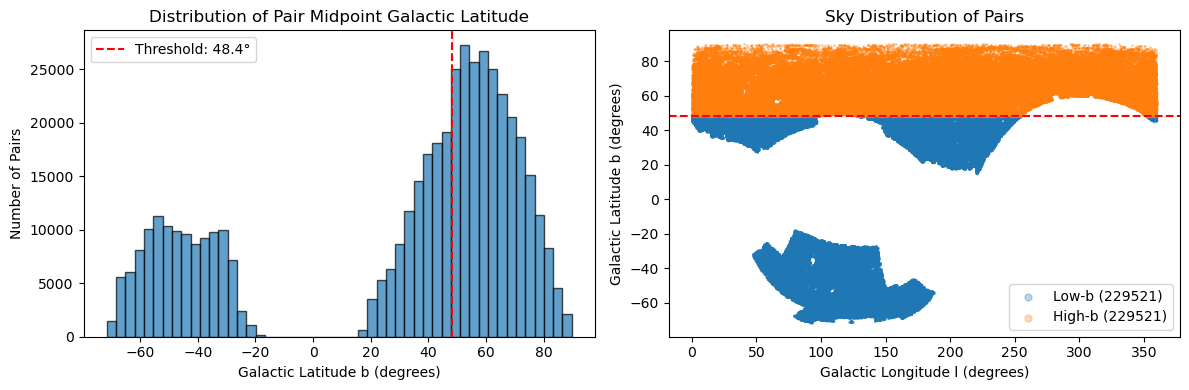

In [102]:
# --- Plot b distribution ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
ax = axes[0]
ax.hist(b_mid, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(b_threshold, color='red', linestyle='--', label=f'Threshold: {b_threshold:.1f}°')
ax.set_xlabel('Galactic Latitude b (degrees)')
ax.set_ylabel('Number of Pairs')
ax.set_title('Distribution of Pair Midpoint Galactic Latitude')
ax.legend()

# Sky distribution
ax = axes[1]
l_mid = (pairs['l1'] + pairs['l2']) / 2
ax.scatter(l_mid[low_b_mask], b_mid[low_b_mask], s=1, alpha=0.3, label=f'Low-b ({low_b_mask.sum()})')
ax.scatter(l_mid[high_b_mask], b_mid[high_b_mask], s=1, alpha=0.3, label=f'High-b ({high_b_mask.sum()})')
ax.axhline(b_threshold, color='red', linestyle='--')
ax.set_xlabel('Galactic Longitude l (degrees)')
ax.set_ylabel('Galactic Latitude b (degrees)')
ax.set_title('Sky Distribution of Pairs')
ax.legend(markerscale=5)

plt.tight_layout()
plt.show()

## Test 4a: Pair Stacking by Galactic Latitude Subsamples

In [103]:
def stack_pairs(pairs_df, kmap, mask, nside, grid_res=101, grid_size=100.0):
    """
    Stack κ maps around galaxy pairs with pair axis aligned along X.
    Returns the stacked map (NOT symmetrized).
    """
    half_size = grid_size / 2
    X_vals = np.linspace(-half_size, half_size, grid_res)
    Y_vals = np.linspace(-half_size, half_size, grid_res)
    X_grid, Y_grid = np.meshgrid(X_vals, Y_vals)
    
    kappa_stack_sum = np.zeros((grid_res, grid_res))
    weight_stack_sum = np.zeros((grid_res, grid_res))
    
    for idx, pair in tqdm(pairs_df.iterrows(), total=len(pairs_df), desc="Stacking pairs"):
        l1, b1, z1 = np.deg2rad(pair['l1']), np.deg2rad(pair['b1']), pair['z1']
        l2, b2, z2 = np.deg2rad(pair['l2']), np.deg2rad(pair['b2']), pair['z2']
        
        # Enforce consistent longitude ordering
        dl_raw = (l2 - l1 + np.pi) % (2*np.pi) - np.pi
        if dl_raw < 0:
            l1, l2 = l2, l1
            b1, b2 = b2, b1
            z1, z2 = z2, z1
            dl_raw = -dl_raw
        
        # Midpoint
        lc = l1 + 0.5 * dl_raw
        bc = 0.5 * (b1 + b2)
        zbar = 0.5 * (z1 + z2)
        Dc = cosmo.comoving_distance(zbar).value * cosmo.h
        
        # Rotation angle
        dl = dl_raw * np.cos(bc)
        db = (b2 - b1)
        norm = np.hypot(dl, db)
        if norm < 1e-10:
            continue
        cos_theta, sin_theta = dl / norm, db / norm
        
        # Transform grid to sky coordinates
        dl_cosbc = (cos_theta * (X_grid / Dc)) - (sin_theta * (Y_grid / Dc))
        db_grid = (sin_theta * (X_grid / Dc)) + (cos_theta * (Y_grid / Dc))
        l_grid = lc + dl_cosbc / np.cos(bc)
        b_grid = bc + db_grid
        
        # Convert to HEALPix
        l_grid_deg = np.rad2deg(l_grid) % 360
        b_grid_deg = np.rad2deg(b_grid)
        theta = np.radians(90 - b_grid_deg)
        
        # Skip if out of valid range
        if np.min(theta) < 0 or np.max(theta) > np.pi:
            continue
        
        phi = np.radians(l_grid_deg)
        pix = hp.ang2pix(nside, theta.ravel(), phi.ravel())
        
        kappa_vals = kmap[pix].reshape(grid_res, grid_res)
        mask_vals = mask[pix].reshape(grid_res, grid_res)
        
        valid_mask = (mask_vals != 0) & np.isfinite(kappa_vals)
        kappa_vals[~valid_mask] = 0.0
        
        kappa_stack_sum += kappa_vals
        weight_stack_sum += valid_mask.astype(float)
    
    # Compute mean
    nonzero = weight_stack_sum > 0
    kappa_stack_mean = np.zeros_like(kappa_stack_sum)
    kappa_stack_mean[nonzero] = kappa_stack_sum[nonzero] / weight_stack_sum[nonzero]
    
    return kappa_stack_mean

In [104]:
def reflect_symmetrize_y_axis(kappa_map):
    """
    Enforce reflection symmetry across the Y axis (left/right mirror).
    """
    h, w = kappa_map.shape
    c = w // 2
    sym = kappa_map.copy()
    left = kappa_map[:, :c+1]
    right = np.fliplr(kappa_map)[:, :c+1]
    avg = 0.5 * (left + right)
    sym[:, :c+1] = avg
    sym[:, c:] = np.fliplr(avg)
    return sym

In [105]:
# --- Stack pairs for each subsample ---
print("="*60)
print("Stacking HIGH-b subsample...")
print("="*60)
pairs_high_b = pairs[high_b_mask].reset_index(drop=True)
kappa_high_b = stack_pairs(pairs_high_b, kmap, mask, nside, grid_res=grid_res)

print("\n" + "="*60)
print("Stacking LOW-b subsample...")
print("="*60)
pairs_low_b = pairs[low_b_mask].reset_index(drop=True)
kappa_low_b = stack_pairs(pairs_low_b, kmap, mask, nside, grid_res=grid_res)

print("\n" + "="*60)
print("Stacking ALL pairs (for reference)...")
print("="*60)
kappa_all = stack_pairs(pairs, kmap, mask, nside, grid_res=grid_res)

print("\nStacking complete!")

Stacking HIGH-b subsample...


Stacking pairs:   0%|          | 0/229521 [00:00<?, ?it/s]


Stacking LOW-b subsample...


Stacking pairs:   0%|          | 0/229521 [00:00<?, ?it/s]


Stacking ALL pairs (for reference)...


Stacking pairs:   0%|          | 0/459042 [00:00<?, ?it/s]


Stacking complete!


In [106]:
# Apply reflection symmetry
kappa_high_b_sym = reflect_symmetrize_y_axis(kappa_high_b)
kappa_low_b_sym = reflect_symmetrize_y_axis(kappa_low_b)
kappa_all_sym = reflect_symmetrize_y_axis(kappa_all)

print("Reflection symmetry applied to all maps.")

Reflection symmetry applied to all maps.


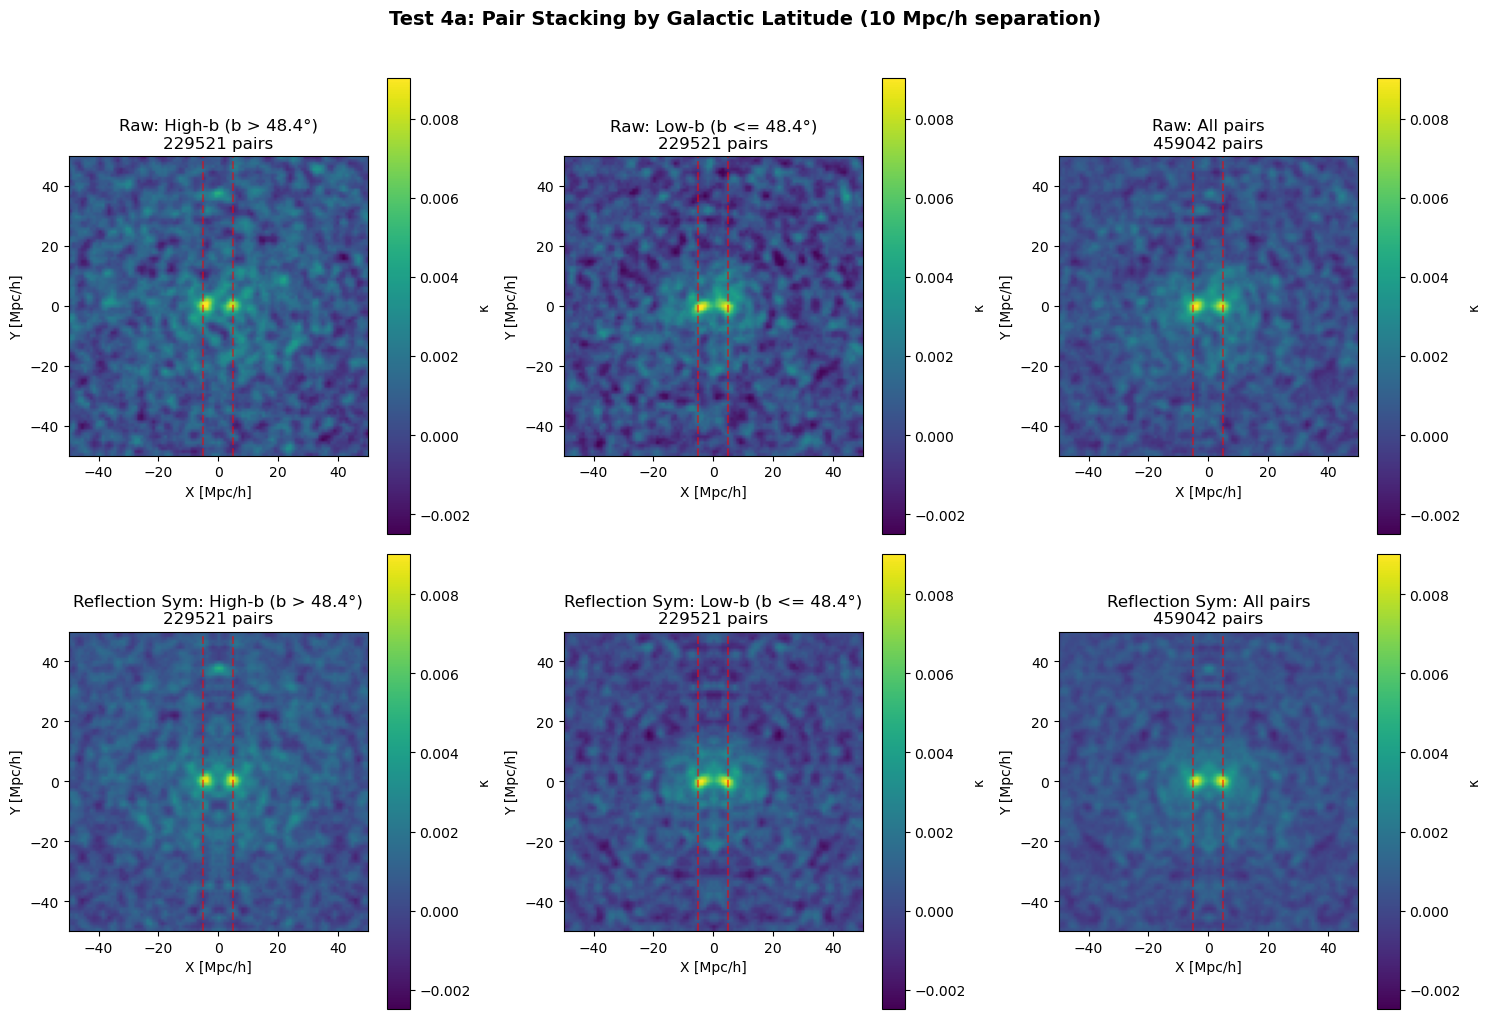

In [107]:
# --- Plot comparison of subsamples ---
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Determine common color scale
all_maps = [kappa_high_b_sym, kappa_low_b_sym, kappa_all_sym]
vmin = min(m.min() for m in all_maps)
vmax = max(m.max() for m in all_maps)

# Row 1: Raw stacked maps
titles_raw = [
    f'High-b (b > {b_threshold:.1f}°)\n{high_b_mask.sum()} pairs',
    f'Low-b (b <= {b_threshold:.1f}°)\n{low_b_mask.sum()} pairs',
    f'All pairs\n{len(pairs)} pairs'
]
maps_raw = [kappa_high_b, kappa_low_b, kappa_all]

for i, (m, t) in enumerate(zip(maps_raw, titles_raw)):
    ax = axes[0, i]
    im = ax.imshow(m, origin='lower', extent=extent, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title(f'Raw: {t}')
    ax.set_xlabel('X [Mpc/h]')
    ax.set_ylabel('Y [Mpc/h]')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    # Mark expected galaxy positions
    ax.axvline(-separation/2, color='red', linestyle='--', alpha=0.5)
    ax.axvline(+separation/2, color='red', linestyle='--', alpha=0.5)
    plt.colorbar(im, ax=ax, label='κ')

# Row 2: Reflection-symmetrized maps
titles_sym = titles_raw
maps_sym = [kappa_high_b_sym, kappa_low_b_sym, kappa_all_sym]

for i, (m, t) in enumerate(zip(maps_sym, titles_sym)):
    ax = axes[1, i]
    im = ax.imshow(m, origin='lower', extent=extent, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title(f'Reflection Sym: {t}')
    ax.set_xlabel('X [Mpc/h]')
    ax.set_ylabel('Y [Mpc/h]')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.axvline(-separation/2, color='red', linestyle='--', alpha=0.5)
    ax.axvline(+separation/2, color='red', linestyle='--', alpha=0.5)
    plt.colorbar(im, ax=ax, label='κ')

plt.suptitle(f'Test 4a: Pair Stacking by Galactic Latitude ({separation} Mpc/h separation)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'plots/test4a_latitude_split_{separation}mpc.png', dpi=150, bbox_inches='tight')
plt.show()

In [108]:
# --- Compute radial profiles around one galaxy peak ---
# Shift maps so one galaxy is at center, then compute radial profile

def compute_radial_profile_from_peak(kappa_map, peak_offset_pix, max_radius_pix=45):
    """
    Compute radial profile centered on a peak at given pixel offset from center.
    """
    ny, nx = kappa_map.shape
    cy, cx = ny // 2, nx // 2
    
    # Center on the peak
    peak_x = cx + peak_offset_pix
    peak_y = cy
    
    y, x = np.indices(kappa_map.shape)
    r = np.sqrt((x - peak_x)**2 + (y - peak_y)**2).astype(int)
    
    r_flat = r.ravel()
    k_flat = kappa_map.ravel()
    
    # Bin by radius
    r_max = min(max_radius_pix, r.max())
    profile = np.zeros(r_max + 1)
    counts = np.zeros(r_max + 1)
    
    for ri in range(r_max + 1):
        mask = r_flat == ri
        if mask.sum() > 0:
            profile[ri] = np.mean(k_flat[mask])
            counts[ri] = mask.sum()
    
    return profile, counts

# Pixel offset for galaxy peak (separation/2 in Mpc/h -> pixels)
peak_offset_pix = int(np.round((separation / 2) / cell_size_hmpc))
print(f"Galaxy peak offset: {separation/2} Mpc/h = {peak_offset_pix} pixels")

# Compute profiles
prof_high_b, _ = compute_radial_profile_from_peak(kappa_high_b_sym, peak_offset_pix)
prof_low_b, _ = compute_radial_profile_from_peak(kappa_low_b_sym, peak_offset_pix)
prof_all, _ = compute_radial_profile_from_peak(kappa_all_sym, peak_offset_pix)

# Convert pixel radius to Mpc/h
r_mpc = np.arange(len(prof_all)) * cell_size_hmpc

Galaxy peak offset: 5.0 Mpc/h = 5 pixels


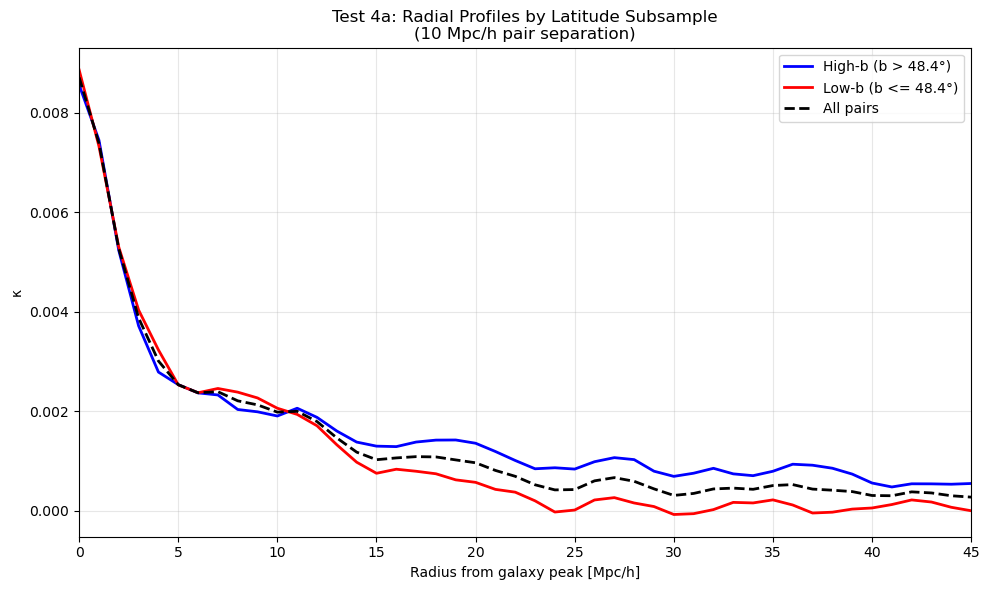


Test 4a Analysis:
Compare the radial profiles above.
If rings appear in BOTH subsamples at same radii -> systematic effect
If rings appear in ONLY ONE subsample -> latitude-dependent artifact
If rings disappear in subsamples -> may be noise/statistics artifact


In [109]:
# --- Plot radial profiles to identify rings ---
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(r_mpc, prof_high_b, 'b-', linewidth=2, label=f'High-b (b > {b_threshold:.1f}°)')
ax.plot(r_mpc, prof_low_b, 'r-', linewidth=2, label=f'Low-b (b <= {b_threshold:.1f}°)')
ax.plot(r_mpc, prof_all, 'k--', linewidth=2, label='All pairs')

# Mark suspected ring positions
for ring_r in []:
    ax.axvline(ring_r, color='gray', linestyle=':', alpha=0.7)
    ax.text(ring_r+0.5, ax.get_ylim()[1]*0.95, f'~{ring_r}', fontsize=9, color='gray')

ax.set_xlabel('Radius from galaxy peak [Mpc/h]')
ax.set_ylabel('κ')
ax.set_title(f'Test 4a: Radial Profiles by Latitude Subsample\n({separation} Mpc/h pair separation)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 45)

plt.tight_layout()
plt.savefig(f'plots/test4a_radial_profiles_{separation}mpc.png', dpi=150, bbox_inches='tight')
plt.show()

# Print analysis
print("\n" + "="*60)
print("Test 4a Analysis:")
print("="*60)
print("Compare the radial profiles above.")
print("If rings appear in BOTH subsamples at same radii -> systematic effect")
print("If rings appear in ONLY ONE subsample -> latitude-dependent artifact")
print("If rings disappear in subsamples -> may be noise/statistics artifact")

## Test 4b: Check Single-Galaxy Stacked Map for Rings

In [110]:
# --- Load or compute single-galaxy stacked map ---
try:
    single_galaxy_map = pd.read_csv("data/kappa_control_original_BOSS_North.csv", index_col=0).values
    print(f"Loaded single-galaxy map: shape {single_galaxy_map.shape}")
except FileNotFoundError:
    print("Single-galaxy map not found. Computing from CMASS catalog...")
    single_galaxy_map = None

Loaded single-galaxy map: shape (100, 100)


In [111]:
# --- Compute single-galaxy stacked map if not available ---
if single_galaxy_map is None:
    print("Loading CMASS North catalog...")
    real_file = "data/BOSS/galaxy_DR12v5_CMASS_North.fits"
    data_real, w_real = load_catalog(real_file, weights="CMASS", z_min=0.4, z_max=0.7)
    
    # Preprocess
    l_arr, b_arr, D_arr, data_filtered, weights_valid = preprocess_catalog_galactic(data_real, w_real)
    print(f"Loaded {len(l_arr)} galaxies")
    
    # Stack single galaxies
    offsets = np.linspace(-half_box + cell_size_hmpc/2, half_box - cell_size_hmpc/2, grid_size)
    off_x, off_y = np.meshgrid(offsets, offsets)
    off_x, off_y = off_x.ravel(), off_y.ravel()
    
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_w = np.zeros(sz)
    
    for i in tqdm(range(len(l_arr)), desc="Stacking single galaxies"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]
        
        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)
        
        l_grid = l + dl
        b_grid = b + db
        
        theta = np.radians(90 - b_grid)
        theta = np.clip(theta, 0, np.pi)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)
        
        w = weights_valid[i] * mask[pix]
        if np.sum(w) == 0:
            continue
        
        k_vals = kmap[pix]
        sum_wk += w * k_vals
        sum_w += w
    
    single_galaxy_map = np.zeros_like(sum_w)
    valid = sum_w > 0
    single_galaxy_map[valid] = sum_wk[valid] / sum_w[valid]
    single_galaxy_map = single_galaxy_map.reshape(grid_size, grid_size)
    
    print(f"Single-galaxy map computed: shape {single_galaxy_map.shape}")

In [112]:
# --- Compute radial profile of single-galaxy map (centered) ---
def compute_centered_radial_profile(kappa_map, max_radius_pix=45):
    """
    Compute radial profile centered on the map center.
    """
    ny, nx = kappa_map.shape
    cy, cx = ny // 2, nx // 2
    
    y, x = np.indices(kappa_map.shape)
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    
    r_flat = r.ravel()
    k_flat = kappa_map.ravel()
    
    r_max = min(max_radius_pix, r.max())
    profile = np.zeros(r_max + 1)
    
    for ri in range(r_max + 1):
        mask = r_flat == ri
        if mask.sum() > 0:
            profile[ri] = np.mean(k_flat[mask])
    
    return profile

# Symmetrize single-galaxy map (radial)
single_galaxy_sym = symmetrize_map(single_galaxy_map)

# Compute radial profiles
prof_single_raw = compute_centered_radial_profile(single_galaxy_map)
prof_single_sym = compute_centered_radial_profile(single_galaxy_sym)

r_mpc_single = np.arange(len(prof_single_raw)) * cell_size_hmpc

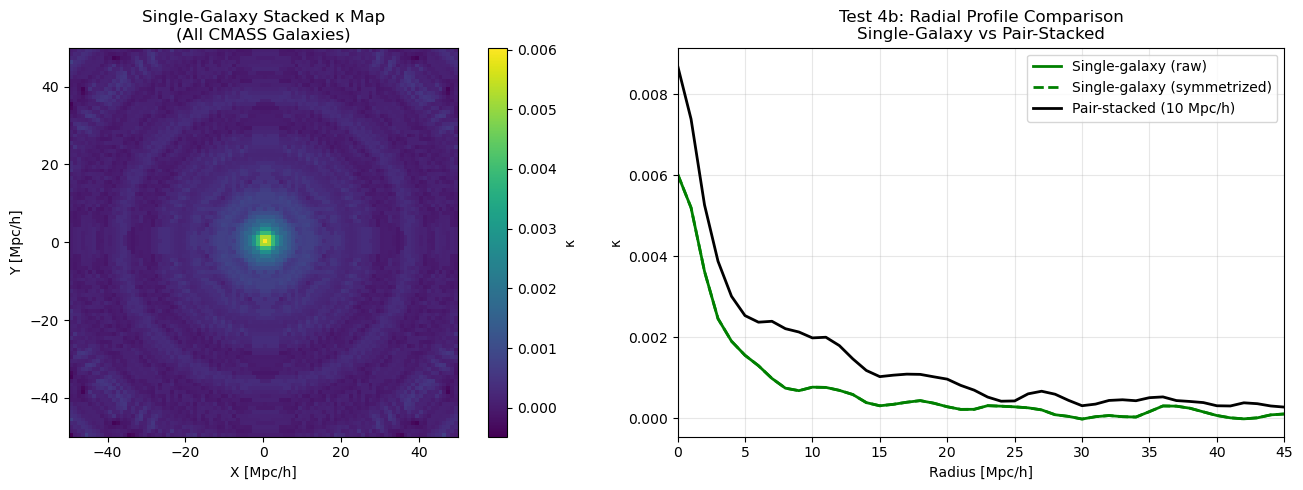

In [113]:
# --- Compare single-galaxy and pair-stacked radial profiles ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Single-galaxy map
ax = axes[0]
im = ax.imshow(single_galaxy_map, origin='lower', extent=extent, cmap='viridis')
ax.set_title('Single-Galaxy Stacked κ Map\n(All CMASS Galaxies)')
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
plt.colorbar(im, ax=ax, label='κ')

# Draw circles at suspected ring radii
for ring_r in []:
    circle = plt.Circle((0, 0), ring_r, fill=False, color='red', linestyle='--', linewidth=2)
    ax.add_patch(circle)
    ax.text(ring_r*0.7, ring_r*0.7, f'{ring_r}', color='red', fontsize=10)

# Right: Radial profile comparison
ax = axes[1]
ax.plot(r_mpc_single, prof_single_raw, 'g-', linewidth=2, label='Single-galaxy (raw)')
ax.plot(r_mpc_single, prof_single_sym, 'g--', linewidth=2, label='Single-galaxy (symmetrized)')
ax.plot(r_mpc[:len(prof_all)], prof_all, 'k-', linewidth=2, label=f'Pair-stacked ({separation} Mpc/h)')

# Mark suspected ring positions
for ring_r in []:
    ax.axvline(ring_r, color='red', linestyle=':', alpha=0.7, label=f'Ring ~{ring_r} Mpc/h' if ring_r == 10 else '')

ax.set_xlabel('Radius [Mpc/h]')
ax.set_ylabel('κ')
ax.set_title('Test 4b: Radial Profile Comparison\nSingle-Galaxy vs Pair-Stacked')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 45)

plt.tight_layout()
plt.savefig(f'plots/test4b_single_vs_pair_{separation}mpc.png', dpi=150, bbox_inches='tight')
plt.show()

In [114]:
# --- Detailed ring analysis: look for local minima/maxima ---
from scipy.signal import find_peaks

def find_ring_features(profile, r_mpc, prominence=0.0001):
    """
    Find peaks and troughs in radial profile that could indicate rings.
    """
    # Find peaks (local maxima)
    peaks, peak_props = find_peaks(profile, prominence=prominence)
    
    # Find troughs (local minima) by inverting
    troughs, trough_props = find_peaks(-profile, prominence=prominence)
    
    return peaks, troughs

print("\n" + "="*60)
print("Ring Feature Detection")
print("="*60)

# Analyze pair-stacked profile
peaks_pair, troughs_pair = find_ring_features(prof_all, r_mpc)
print(f"\nPair-stacked map ({separation} Mpc/h):")
print(f"  Peaks at radii: {r_mpc[peaks_pair]} Mpc/h")
print(f"  Troughs at radii: {r_mpc[troughs_pair]} Mpc/h")

# Analyze single-galaxy profile
peaks_single, troughs_single = find_ring_features(prof_single_raw, r_mpc_single)
print(f"\nSingle-galaxy map:")
print(f"  Peaks at radii: {r_mpc_single[peaks_single]} Mpc/h")
print(f"  Troughs at radii: {r_mpc_single[troughs_single]} Mpc/h")

# Compare
print("\n" + "-"*60)
print("Comparison:")
print("-"*60)
if len(peaks_pair) > 0 and len(peaks_single) > 0:
    common_peaks = []
    for p in r_mpc[peaks_pair]:
        for s in r_mpc_single[peaks_single]:
            if abs(p - s) < 3:  # Within 3 Mpc/h
                common_peaks.append((p, s))
    if common_peaks:
        print(f"Common peak positions (within 3 Mpc/h):")
        for p, s in common_peaks:
            print(f"  Pair: {p:.1f} Mpc/h, Single: {s:.1f} Mpc/h")
        print("\n=> Rings likely originate from single-galaxy stacking, not pair alignment!")
    else:
        print("No common peak positions found.")
        print("\n=> Rings may be specific to pair stacking procedure.")


Ring Feature Detection

Pair-stacked map (10 Mpc/h):
  Peaks at radii: [27. 36.] Mpc/h
  Troughs at radii: [24. 30.] Mpc/h

Single-galaxy map:
  Peaks at radii: [18. 36.] Mpc/h
  Troughs at radii: [15. 30. 42.] Mpc/h

------------------------------------------------------------
Comparison:
------------------------------------------------------------
Common peak positions (within 3 Mpc/h):
  Pair: 36.0 Mpc/h, Single: 36.0 Mpc/h

=> Rings likely originate from single-galaxy stacking, not pair alignment!


## Summary and Conclusions

In [115]:
print("="*70)
print("RING ARTIFACT INVESTIGATION SUMMARY")
print("="*70)

print(f"\nPair separation analyzed: {separation} Mpc/h")
print(f"Total pairs: {len(pairs)}")
print(f"High-b subsample: {high_b_mask.sum()} pairs (b > {b_threshold:.1f}°)")
print(f"Low-b subsample: {low_b_mask.sum()} pairs (b <= {b_threshold:.1f}°)")

print("\n" + "-"*70)
print("TEST 4a: Latitude Split Results")
print("-"*70)
print("Check the plots above to determine:")
print("  - Do rings appear in BOTH high-b and low-b subsamples?")
print("  - Are ring positions/amplitudes similar in both?")
print("  - If yes to both: rings are NOT latitude-dependent")

print("\n" + "-"*70)
print("TEST 4b: Single-Galaxy Map Results")
print("-"*70)
print("Check the radial profile comparison to determine:")
print("  - Do similar features appear in the single-galaxy radial profile?")
print("  - If yes: rings originate from the κ map itself, not pair alignment")
print("  - If no: rings may be an artifact of the pair stacking rotation/alignment")

print("\n" + "-"*70)
print("POSSIBLE EXPLANATIONS FOR RINGS")
print("-"*70)
print("1. HEALPix pixelization artifacts at certain angular scales")
print("2. Planck κ map noise correlation at specific scales")
print("3. Smoothing kernel effects (8 arcmin FWHM)")
print("4. Coordinate transformation artifacts in pair rotation")
print("5. Edge effects from the survey mask")

print("\n" + "="*70)
print("Plots saved to 'plots/' directory.")
print("="*70)

RING ARTIFACT INVESTIGATION SUMMARY

Pair separation analyzed: 10 Mpc/h
Total pairs: 459042
High-b subsample: 229521 pairs (b > 48.4°)
Low-b subsample: 229521 pairs (b <= 48.4°)

----------------------------------------------------------------------
TEST 4a: Latitude Split Results
----------------------------------------------------------------------
Check the plots above to determine:
  - Do rings appear in BOTH high-b and low-b subsamples?
  - Are ring positions/amplitudes similar in both?
  - If yes to both: rings are NOT latitude-dependent

----------------------------------------------------------------------
TEST 4b: Single-Galaxy Map Results
----------------------------------------------------------------------
Check the radial profile comparison to determine:
  - Do similar features appear in the single-galaxy radial profile?
  - If yes: rings originate from the κ map itself, not pair alignment
  - If no: rings may be an artifact of the pair stacking rotation/alignment

-------